In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn import set_config
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This function allows us to create a submission easily

In [2]:
def make_submission():
    submission = titanic_test.copy()
    #display(titanic_test)
    Y_test_pred = model.predict(X_test)
    display(X_test)
    submission['Survived'] = Y_test_pred
    submission.drop(submission.iloc[:, 1:-1], inplace=True, axis=1)
    submission = submission.set_index('PassengerId')
    display(submission)
    submission.to_csv('/kaggle/working/submissionZ.csv')

# Titanic - Machine Learning from Disaster

Is it possible to predict whether someone will survive a given disaster? That is the question we'll try to answer.

Here, we'll be using the example of the Titanic and its passengers. 

## Let's load the data

# Explanations for the columns of our dataset:

**Variable**	Definition	Key
**survival**	Survival	0 = No, 1 = Yes
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
**Parent** = mother, father
**Child** = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Data Exploration

In [3]:
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(titanic_train.shape)
display(titanic_train)


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We can see that there are 11 features and we are trying to predict the survived column. 

Some columns like Age and Cabin seem to cointain NaN values which is a problem. We'll have to make sure to remove the corresponding lines.

The ticket number doesn't give much information since we already have the fare and the cabin. Thus, we can delete this column.
Same goes for the Name column

We'll use one-hot vectors for Sex and Embarked 





Text(0.5, 1.0, 'Survived (binary: yes or no)')

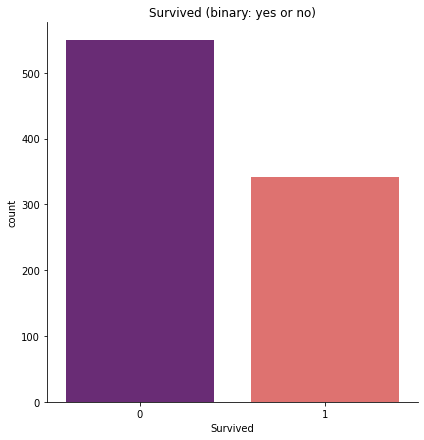

In [4]:
sns.catplot(x="Survived", kind="count",palette="magma", data=titanic_train, height = 6)
plt.title("Survived (binary: yes or no)")

# Data Preparation

We will build a pipeline so that we can clean our data easily.

In [5]:
#constants
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
target = 'Survived'

def pipeline(numerical_imputer, numerical_scaler, numerical_features, categorical_imputer, categorical_encoder, categorical_features, estimator):
    numerical_transformer = Pipeline(
        steps=[
            ("numerical_imputer", numerical_imputer),
            ("numerical_scaler", numerical_scaler),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("categorical_imputer", categorical_imputer),
            ("categorical_encoder", categorical_encoder),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    clf = Pipeline( 
        steps=[("preprocessor", preprocessor), ("classifier", estimator)]
    )
    return clf

In [6]:
#parameters of the pipeline
random_state = 0
numerical_imputer = SimpleImputer(strategy='mean')
numerical_scaler = StandardScaler()
numerical_features = ['Age', 'Fare']
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_features = ['Pclass'
            , 'Sex'	
            , 'SibSp'
            , 'Parch'
            , 'Ticket'
            , 'Embarked'
           ]


In [7]:
X_train = titanic_train[numerical_features + categorical_features]
X_test = titanic_test[numerical_features + categorical_features]
y_train = titanic_train[target]

Our baseline will be the result of a Perceptron algorithm

In [8]:
estimator = Perceptron(random_state = random_state)

In [9]:
model = pipeline(numerical_imputer = numerical_imputer
                 , numerical_scaler = numerical_scaler
                 , numerical_features = numerical_features  
                 , categorical_imputer = categorical_imputer
                 , categorical_encoder = categorical_encoder
                 , categorical_features = categorical_features
                 , estimator = estimator)

In [10]:
set_config(display="diagram")
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer()),
                                                                  ('numerical_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Ticket',
                                                   'Embarked'])])),
                ('classifier', Perceptron())])

In [11]:
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Average CV score:", scores.mean())

Average CV score: 0.8058426966292135


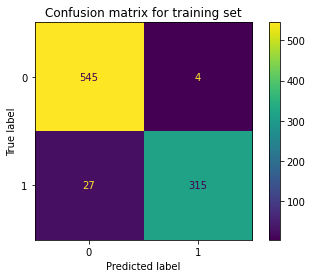

In [12]:
model.fit(X_train, y_train)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()


Let's try another model using, XGBoost :

In [13]:
estimator = GradientBoostingClassifier(random_state = random_state)
model = pipeline(numerical_imputer = numerical_imputer
                 , numerical_scaler = numerical_scaler
                 , numerical_features = numerical_features  
                 , categorical_imputer = categorical_imputer
                 , categorical_encoder = categorical_encoder
                 , categorical_features = categorical_features
                 , estimator = estimator)

In [14]:
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Average CV score:", scores.mean())

Average CV score: 0.8148439450686642


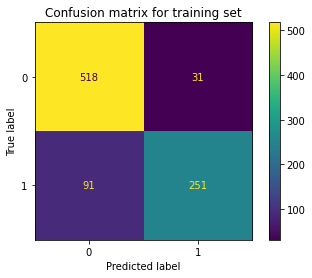

In [15]:
model.fit(X_train, y_train)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()


In [16]:
make_submission()

,Age,Fare,Pclass,Sex,SibSp,Parch,Ticket,Embarked
0,34.5,7.8292,3,male,0,0,330911,Q
1,47.0,7.0000,3,female,1,0,363272,S
2,62.0,9.6875,2,male,0,0,240276,Q
3,27.0,8.6625,3,male,0,0,315154,S
4,22.0,12.2875,3,female,1,1,3101298,S
...,...,...,...,...,...,...,...,...
413,NaN,8.0500,3,male,0,0,A.5. 3236,S
414,39.0,108.9000,1,female,0,0,PC 17758,C
415,38.5,7.2500,3,male,0,0,SOTON/O.Q. 3101262,S
416,NaN,8.0500,3,male,0,0,359309,S


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


#First we are going to remove useless columns

titanic_train = titanic_train.drop(['Name', 'Ticket'], axis = 1)

titanic_test = titanic_test.drop(['Name', 'Ticket'], axis = 1)
#Next we remove NaN values.
#Let's count them:
print(titanic_train.isnull().sum(axis = 0))
print(titanic_test.isnull().sum(axis = 0))



We can see that there are many missing values for the cabin numbers,we can drop that column.
We can also remove the examples for which there is no age.

In [17]:
"""titanic_train = titanic_train.drop(['Cabin'], axis = 1)

titanic_test = titanic_test.drop(['Cabin'], axis = 1)

#titanic_train = titanic_train.dropna()
#titanic_test = titanic_test.dropna()
titanic_train = titanic_train.fillna(0)
titanic_test = titanic_test.fillna(0)"""

"titanic_train = titanic_train.drop(['Cabin'], axis = 1)\n\ntitanic_test = titanic_test.drop(['Cabin'], axis = 1)\n\n#titanic_train = titanic_train.dropna()\n#titanic_test = titanic_test.dropna()\ntitanic_train = titanic_train.fillna(0)\ntitanic_test = titanic_test.fillna(0)"

### display(titanic_train)
display(titanic_test)

Now we use one-hot encoding for the Sex and Embarked column

In [18]:
"""titanic_train = pd.get_dummies(titanic_train,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])
titanic_test = pd.get_dummies(titanic_test,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])
display(titanic_train)
display(titanic_test)
titanic_train = titanic_train.drop('Embarked_0', axis=1)"""

"titanic_train = pd.get_dummies(titanic_train,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])\ntitanic_test = pd.get_dummies(titanic_test,prefix=['Sex', 'Embarked'], columns = ['Sex', 'Embarked'])\ndisplay(titanic_train)\ndisplay(titanic_test)\ntitanic_train = titanic_train.drop('Embarked_0', axis=1)"

Now we can standardize the Fare and Age 

In [19]:
"""from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
titanic_train[['Age', 'Fare']] = scaler.fit_transform(titanic_train[['Age', 'Fare']])
titanic_test[['Age', 'Fare']] = scaler.fit_transform(titanic_test[['Age', 'Fare']])
display(titanic_train)
"""

"from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\ntitanic_train[['Age', 'Fare']] = scaler.fit_transform(titanic_train[['Age', 'Fare']])\ntitanic_test[['Age', 'Fare']] = scaler.fit_transform(titanic_test[['Age', 'Fare']])\ndisplay(titanic_train)\n"

Let's observe our data by plotting some of the features

In [20]:
"""sns.catplot(x="Survived", kind="count",palette="magma", data=titanic_train, height = 6)
plt.title("Survived (binary: yes or no)")"""

'sns.catplot(x="Survived", kind="count",palette="magma", data=titanic_train, height = 6)\nplt.title("Survived (binary: yes or no)")'

We can see that not everyone died, almost 300 people survived. Thus the classes aren't very imbalanced.

We then create a correlation matrix.
We can observe interesting correlation like between sex and survival or survival and socio-economic status

In [21]:
"""### plt.figure(figsize=(25,13))
sns.heatmap(titanic_train.corr(),annot=True,cmap="coolwarm")
plt.show()"""

'### plt.figure(figsize=(25,13))\nsns.heatmap(titanic_train.corr(),annot=True,cmap="coolwarm")\nplt.show()'

# TRAINING

First we'll create our train/test split:


In [22]:
"""test_ratio = 0.30
Y = titanic_train.Survived

X = titanic_train.drop(['Survived', 'PassengerId'], axis = 1)
X_train, X_val,  Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, random_state=0)
"""

"test_ratio = 0.30\nY = titanic_train.Survived\n\nX = titanic_train.drop(['Survived', 'PassengerId'], axis = 1)\nX_train, X_val,  Y_train, Y_val = train_test_split(X, Y, test_size=test_ratio, random_state=0)\n"

# Baseline method

We will use a perceptron as a first method of prediction

In [23]:
"""from sklearn.linear_model import Perceptron

model = Perceptron(tol=1e-3, random_state=0)
model.fit(X_train, Y_train)
display(X_train)
Y_train_pred = model.predict(X_train)
print("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))

Y_val_pred = model.predict(X_val)
print("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))
"""



'from sklearn.linear_model import Perceptron\n\nmodel = Perceptron(tol=1e-3, random_state=0)\nmodel.fit(X_train, Y_train)\ndisplay(X_train)\nY_train_pred = model.predict(X_train)\nprint("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))\n\nY_val_pred = model.predict(X_val)\nprint("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))\n'

In [24]:
"""print(Y_train[:20])
print(Y_train_pred[:20])"""

'print(Y_train[:20])\nprint(Y_train_pred[:20])'

In [25]:
"""from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

# Create a pipeline; This will be passed as an estimator to learning curve method
#
pipeline = make_pipeline(Perceptron(tol=1e-3, random_state=0))
#
# Use learning curve to get training and test scores along with train sizes
#
train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=Y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()"""

"from sklearn.model_selection import train_test_split\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import learning_curve\nfrom sklearn import datasets\nimport matplotlib.pyplot as plt\n\n# Create a pipeline; This will be passed as an estimator to learning curve method\n#\npipeline = make_pipeline(Perceptron(tol=1e-3, random_state=0))\n#\n# Use learning curve to get training and test scores along with train sizes\n#\ntrain_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=Y_train,\n                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),\n                                                     n_jobs=1)\n#\n# Calculate training and test mean and std\n#\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\ntest_

In [26]:
"""from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()
"""

"from sklearn.metrics import ConfusionMatrixDisplay\n\nConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)\nplt.title('Confusion matrix for training set' )\nplt.show()\n"

In [27]:
"""
ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)
plt.title('Confusion matrix for validation set' )
plt.show()"""

"\nConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)\nplt.title('Confusion matrix for validation set' )\nplt.show()"

# Result

This first strategy yields a 0.69856 score for the test set. We can say that we predicted the right outcome for approximately 70% of the passengers.
We'll now try to improve this result.

# Logistic Regression

Next we can try to use a logistic regression algorithm.

In [28]:
"""from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty = 'none', random_state=0)
model.fit(X_train, Y_train)
display(X_train)
Y_train_pred = model.predict(X_train)
print("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))

Y_val_pred = model.predict(X_val)
print("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))"""


'from sklearn.linear_model import LogisticRegression\nmodel = LogisticRegression(penalty = \'none\', random_state=0)\nmodel.fit(X_train, Y_train)\ndisplay(X_train)\nY_train_pred = model.predict(X_train)\nprint("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))\n\nY_val_pred = model.predict(X_val)\nprint("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))'

In [29]:
"""ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()
"""

"ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)\nplt.title('Confusion matrix for training set' )\nplt.show()\n"

In [30]:
"""ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)
plt.title('Confusion matrix for validation set' )
plt.show()"""

"ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)\nplt.title('Confusion matrix for validation set' )\nplt.show()"

There is an improvement on the accury of our model.We can still improve

# Neural Network

In [31]:
"""from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
hidden_layer_sizes = (100,2), random_state=0, max_iter=1000)
model.fit(X_train, Y_train)
Y_train_pred = model.predict(X_train)

Y_train_pred = model.predict(X_train)
print("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))

Y_val_pred = model.predict(X_val)
print("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))"""

'from sklearn.neural_network import MLPClassifier\n\nmodel = MLPClassifier(\nhidden_layer_sizes = (100,2), random_state=0, max_iter=1000)\nmodel.fit(X_train, Y_train)\nY_train_pred = model.predict(X_train)\n\nY_train_pred = model.predict(X_train)\nprint("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))\n\nY_val_pred = model.predict(X_val)\nprint("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))'

In [32]:
"""ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()
"""

"ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)\nplt.title('Confusion matrix for training set' )\nplt.show()\n"

In [33]:
"""ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)
plt.title('Confusion matrix for validation set' )
plt.show()"""

"ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)\nplt.title('Confusion matrix for validation set' )\nplt.show()"

In [34]:
"""submission = titanic_test.copy()
display(titanic_test)
X_test = submission.drop('PassengerId', axis= 1)
display(X_test)
Y_test_pred = model.predict(X_test)
display(X_test)
submission['Survived'] = Y_test_pred
submission.drop(submission.iloc[:, 1:-1], inplace=True, axis=1)
submission = submission.set_index('PassengerId')"""

"submission = titanic_test.copy()\ndisplay(titanic_test)\nX_test = submission.drop('PassengerId', axis= 1)\ndisplay(X_test)\nY_test_pred = model.predict(X_test)\ndisplay(X_test)\nsubmission['Survived'] = Y_test_pred\nsubmission.drop(submission.iloc[:, 1:-1], inplace=True, axis=1)\nsubmission = submission.set_index('PassengerId')"

# Random Forest

In [35]:
"""from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=1000, max_depth=4)
model.fit(X_train, Y_train)
Y_train_pred = model.predict(X_train)

Y_train_pred = model.predict(X_train)
print("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))

Y_val_pred = model.predict(X_val)
print("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))"""

'from sklearn.ensemble import GradientBoostingClassifier\n\nmodel = GradientBoostingClassifier(n_estimators=1000, max_depth=4)\nmodel.fit(X_train, Y_train)\nY_train_pred = model.predict(X_train)\n\nY_train_pred = model.predict(X_train)\nprint("train accuracy ", sklearn.metrics.accuracy_score(Y_train_pred, Y_train))\n\nY_val_pred = model.predict(X_val)\nprint("val accuracy", sklearn.metrics.accuracy_score(Y_val_pred, Y_val))'

In [36]:
"""ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)
plt.title('Confusion matrix for training set' )
plt.show()
"""

"ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)\nplt.title('Confusion matrix for training set' )\nplt.show()\n"

In [37]:
"""ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)
plt.title('Confusion matrix for validation set' )
plt.show()"""

"ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred)\nplt.title('Confusion matrix for validation set' )\nplt.show()"